## Time series clustering exercise

### Data

Download the census bureau business data for 1993-2014.
Note: if wget is not installed (as in my case) you can install it easily through command line if you have homebrew by runnin on your command line  " _brew install wget_ "

### CANNOT FIND '93

In [ ]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once

!for ((y=93; y<=99; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done
 
!for ((y=2; y<=9; y+=1)); do wget \
ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

!for ((y=10; y<=14; y+=1)); do wget \
ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

In [1]:
import pandas as pd
import pylab as pl
import geopandas as gpd
import choroplethNYC as cp
import zipfile 
import urllib
import os
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.cluster as scp
from scipy.cluster.hierarchy import fcluster
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
random.seed(1993)

In [3]:
url_shape = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url_shape, 'shape_file.zip')
os.system("mv shape_file.zip" + os.getenv("PUIDATA"))
os.system("unzip "+ os.getenv("PUIDATA") + "/shape_file.zip -d " + os.getenv("PUIDATA"))

2304

In [4]:
#deal with shape file import...
filename = ! ls $PUIDATA/ZIP_CODE_040114/ZIP*.shp
filename = filename[0]

In [5]:
zipshape = gpd.GeoDataFrame.from_file(filename)

In [6]:
zipshape.shape

(263, 13)

In [7]:
zipshapegeom = zipshape[["ZIPCODE","geometry"]]
zipshape = zipshape[["ZIPCODE"]]
zipshape.head()

,ZIPCODE
0,11436
1,11213
2,11212
3,11225
4,11218


In [8]:
zipshape["ZIPCODE"]  = zipshape.ZIPCODE.astype(int)
zipshapegeom["ZIPCODE"] = zipshapegeom.ZIPCODE.astype(int)

In [9]:
want_years = np.arange(95,100)
want_years = np.append(want_years,["%.2d" % i for i in range(15)])
want_years

array(['95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05',
       '06', '07', '08', '09', '10', '11', '12', '13', '14'],
      dtype='<U21')

In [10]:
fname = "zbp" + str(94) + "totals.zip"
zf = zipfile.ZipFile(fname)
firstDf = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
firstDf.columns = map(str.lower, firstDf.columns)
firstDf = firstDf[["zip","est"]]
firstDf.rename(columns = {"ZIP".lower() : "ZIPCODE", "EST".lower() : "est" + str(94)}, inplace = True)

for y in want_years :
    fname = "zbp" + str(y) + "totals.zip"
    zf = zipfile.ZipFile(fname)
    newDf = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    newDf.columns = map(str.lower, newDf.columns)
    newDf = newDf[["zip","est"]]
    newDf.rename(columns = {"ZIP".lower() : "ZIPCODE", "EST".lower() : "est" + str(y)}, inplace = True)
    firstDf = pd.merge(firstDf,newDf)

In [11]:
firstDf.head()

,ZIPCODE,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,1001,439,439,433,457,444,469,493,490,490,...,509,509,503,477,458,448,436,453,439,458
1,1002,450,467,487,500,490,558,563,587,566,...,589,582,596,584,571,570,558,572,572,560
2,1003,10,10,13,15,14,13,13,13,15,...,12,12,16,17,16,16,16,15,15,18
3,1004,47,48,47,41,31,35,48,37,23,...,31,30,20,18,18,21,19,16,16,13
4,1005,92,95,101,104,95,82,86,90,94,...,94,98,106,97,87,96,91,94,97,97


In [12]:
firstDf.shape

(35885, 22)

In [13]:
fullData = pd.merge(firstDf, zipshape)

In [14]:
fullData.set_index("ZIPCODE",inplace = True)

In [15]:
fullData.head()

,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,...,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,...,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,...,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554


In [16]:
fullData.shape

(243, 21)

In [17]:
normData = fullData

In [18]:
for i in range(fullData.shape[0]):
    a = ((fullData.iloc[i]-fullData.iloc[i].mean())/fullData.iloc[i].std())
    normData.iloc[i] = a.values

In [19]:
print("shape is : " + str(normData.shape))
normData.head()

shape is : (243, 21)


,est94,est95,est96,est97,est98,est99,est00,est01,est02,est03,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
ZIPCODE,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945


In [20]:
#check that all rows are mean 0 and std 1
for i in range(normData.shape[0]):
    if round(normData.iloc[i].mean(),2) != 0 or round(normData.iloc[i].std(),2) != 1:
        print("ATTENTION!! Row {} has a mean of {:.2f} and a std dev of {:.2f}".format(i,normData.iloc[i].mean(), normData.iloc[i].std()))

In [21]:
km = KMeans(n_clusters = 6)
km.fit(normData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
centroids = (km.cluster_centers_)
centroids.shape

(6, 21)

In [23]:
normData["cluster"] = km.labels_

In [24]:
sns.set_style("whitegrid")

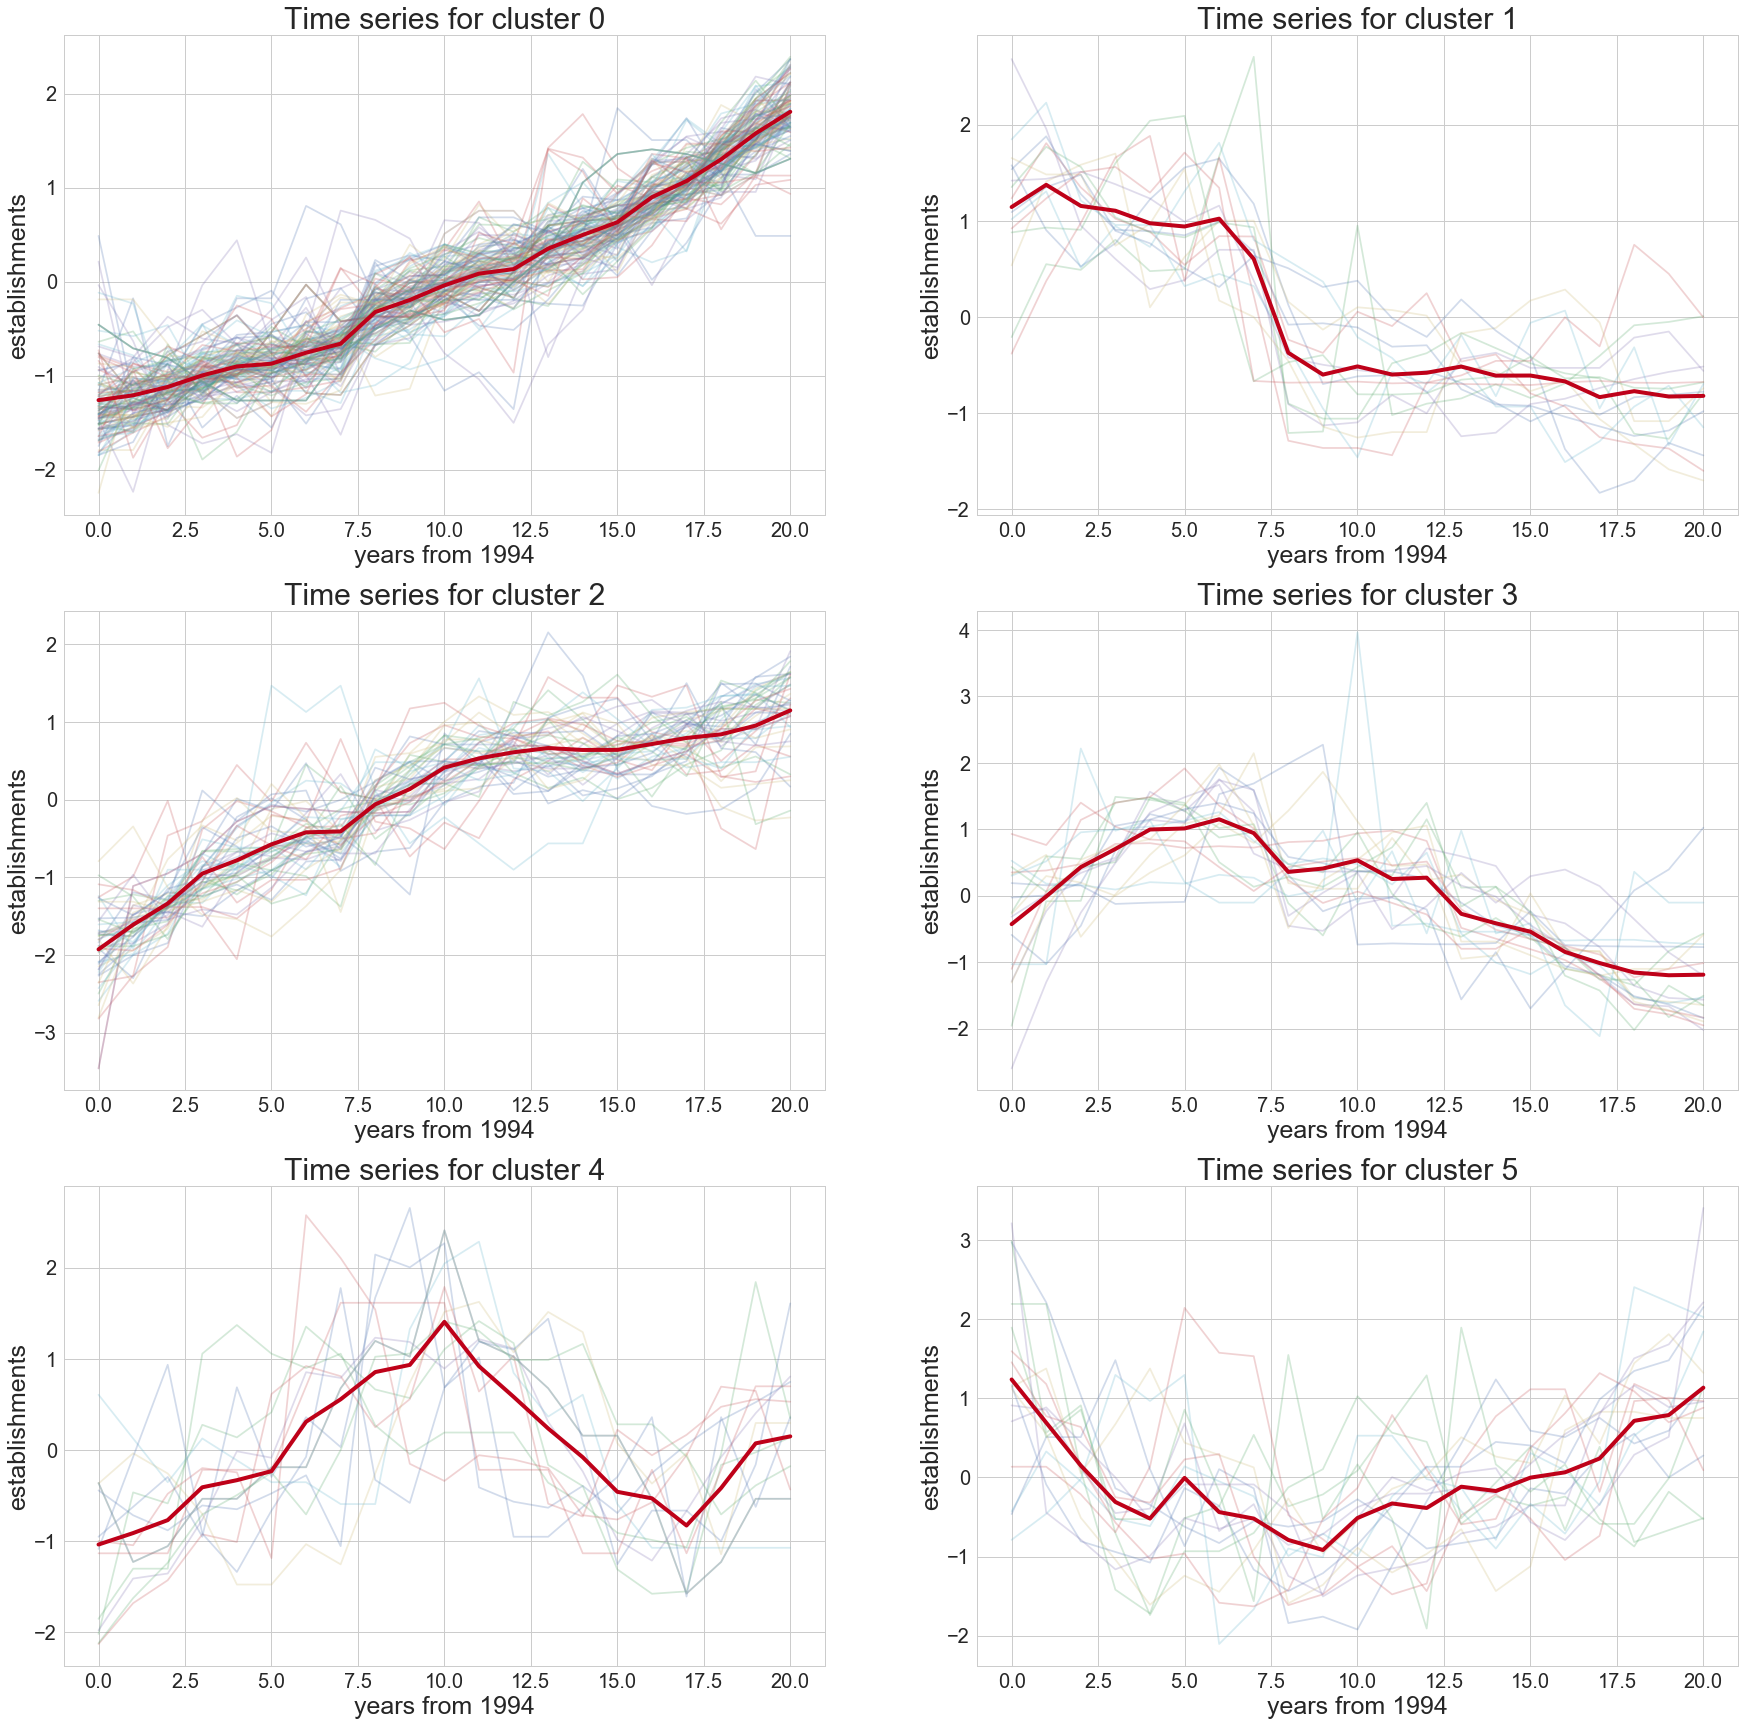

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(30,30))

for c,ax in enumerate(fig.axes):
    for i in range(normData.shape[0]):
        if normData["cluster"].iloc[i] == c :
            ax.plot(range(21), normData.iloc[i,:-1].values, alpha = 0.25)
    ax.plot(range(21), centroids[c], sns.xkcd_rgb["scarlet"], lw = 4)
    ax.set_xlabel("years from 1994", fontsize =25)
    ax.set_ylabel("establishments",fontsize =25)
    ax.set_title("Time series for cluster {}".format(c), fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=20)

__Figure 1__ : Number of establishments' (normalized) between 1994 and 2004, timeseries. The trends are clustered by K-means clustering algorithm and the centroids are plotted in red.

In [26]:
normDataGeo = normData.reset_index()

In [27]:
normDataGeo.shape

(243, 23)

In [28]:
zipshapegeom.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [29]:
zipshapegeom = zipshapegeom.drop_duplicates("ZIPCODE")

In [30]:
zipshapegeom.shape

(248, 2)

In [31]:
normDataGeo = pd.merge(normDataGeo,zipshapegeom)

In [32]:
normDataGeo.shape

(243, 24)

In [33]:
normDataGeo = gpd.GeoDataFrame(normDataGeo, geometry = "geometry")

In [34]:
normDataGeo.head()

,ZIPCODE,est94,est95,est96,est97,est98,est99,est00,est01,est02,...,est07,est08,est09,est10,est11,est12,est13,est14,cluster,geometry
0,10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,...,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,2,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,...,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,2,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,...,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,...,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0,"POLYGON ((981197.408652395 196571.0816452205, ..."


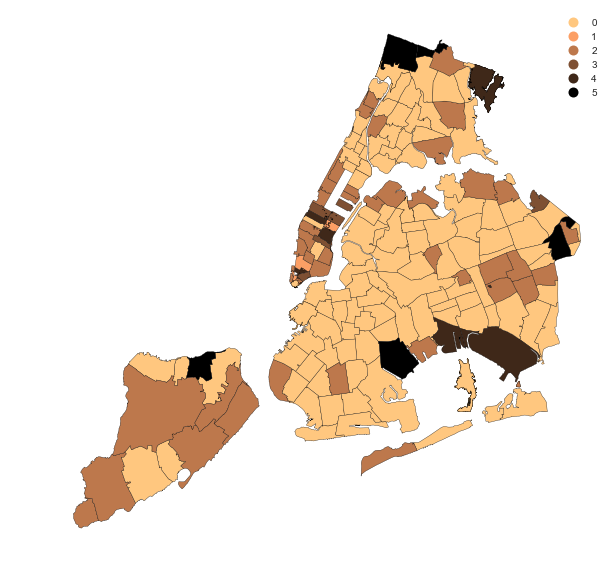

In [35]:
fig, ax = pl.subplots(figsize=(10, 10))
axis("off")
normDataGeo.plot(column = "cluster", ax= ax, edgecolor='black', categorical = True, cmap = "copper_r",legend = True);
ax.set_title = "Cloropleth of NYC by zip divided by K-mean clusters",

__Figure 2__ Cloropleth of NYC by zipcode, clustered by number of establishment's timeseries from 1994 to 2004. Clustering algorithm = K-means clustering with 6 clusters.

## Dendogram

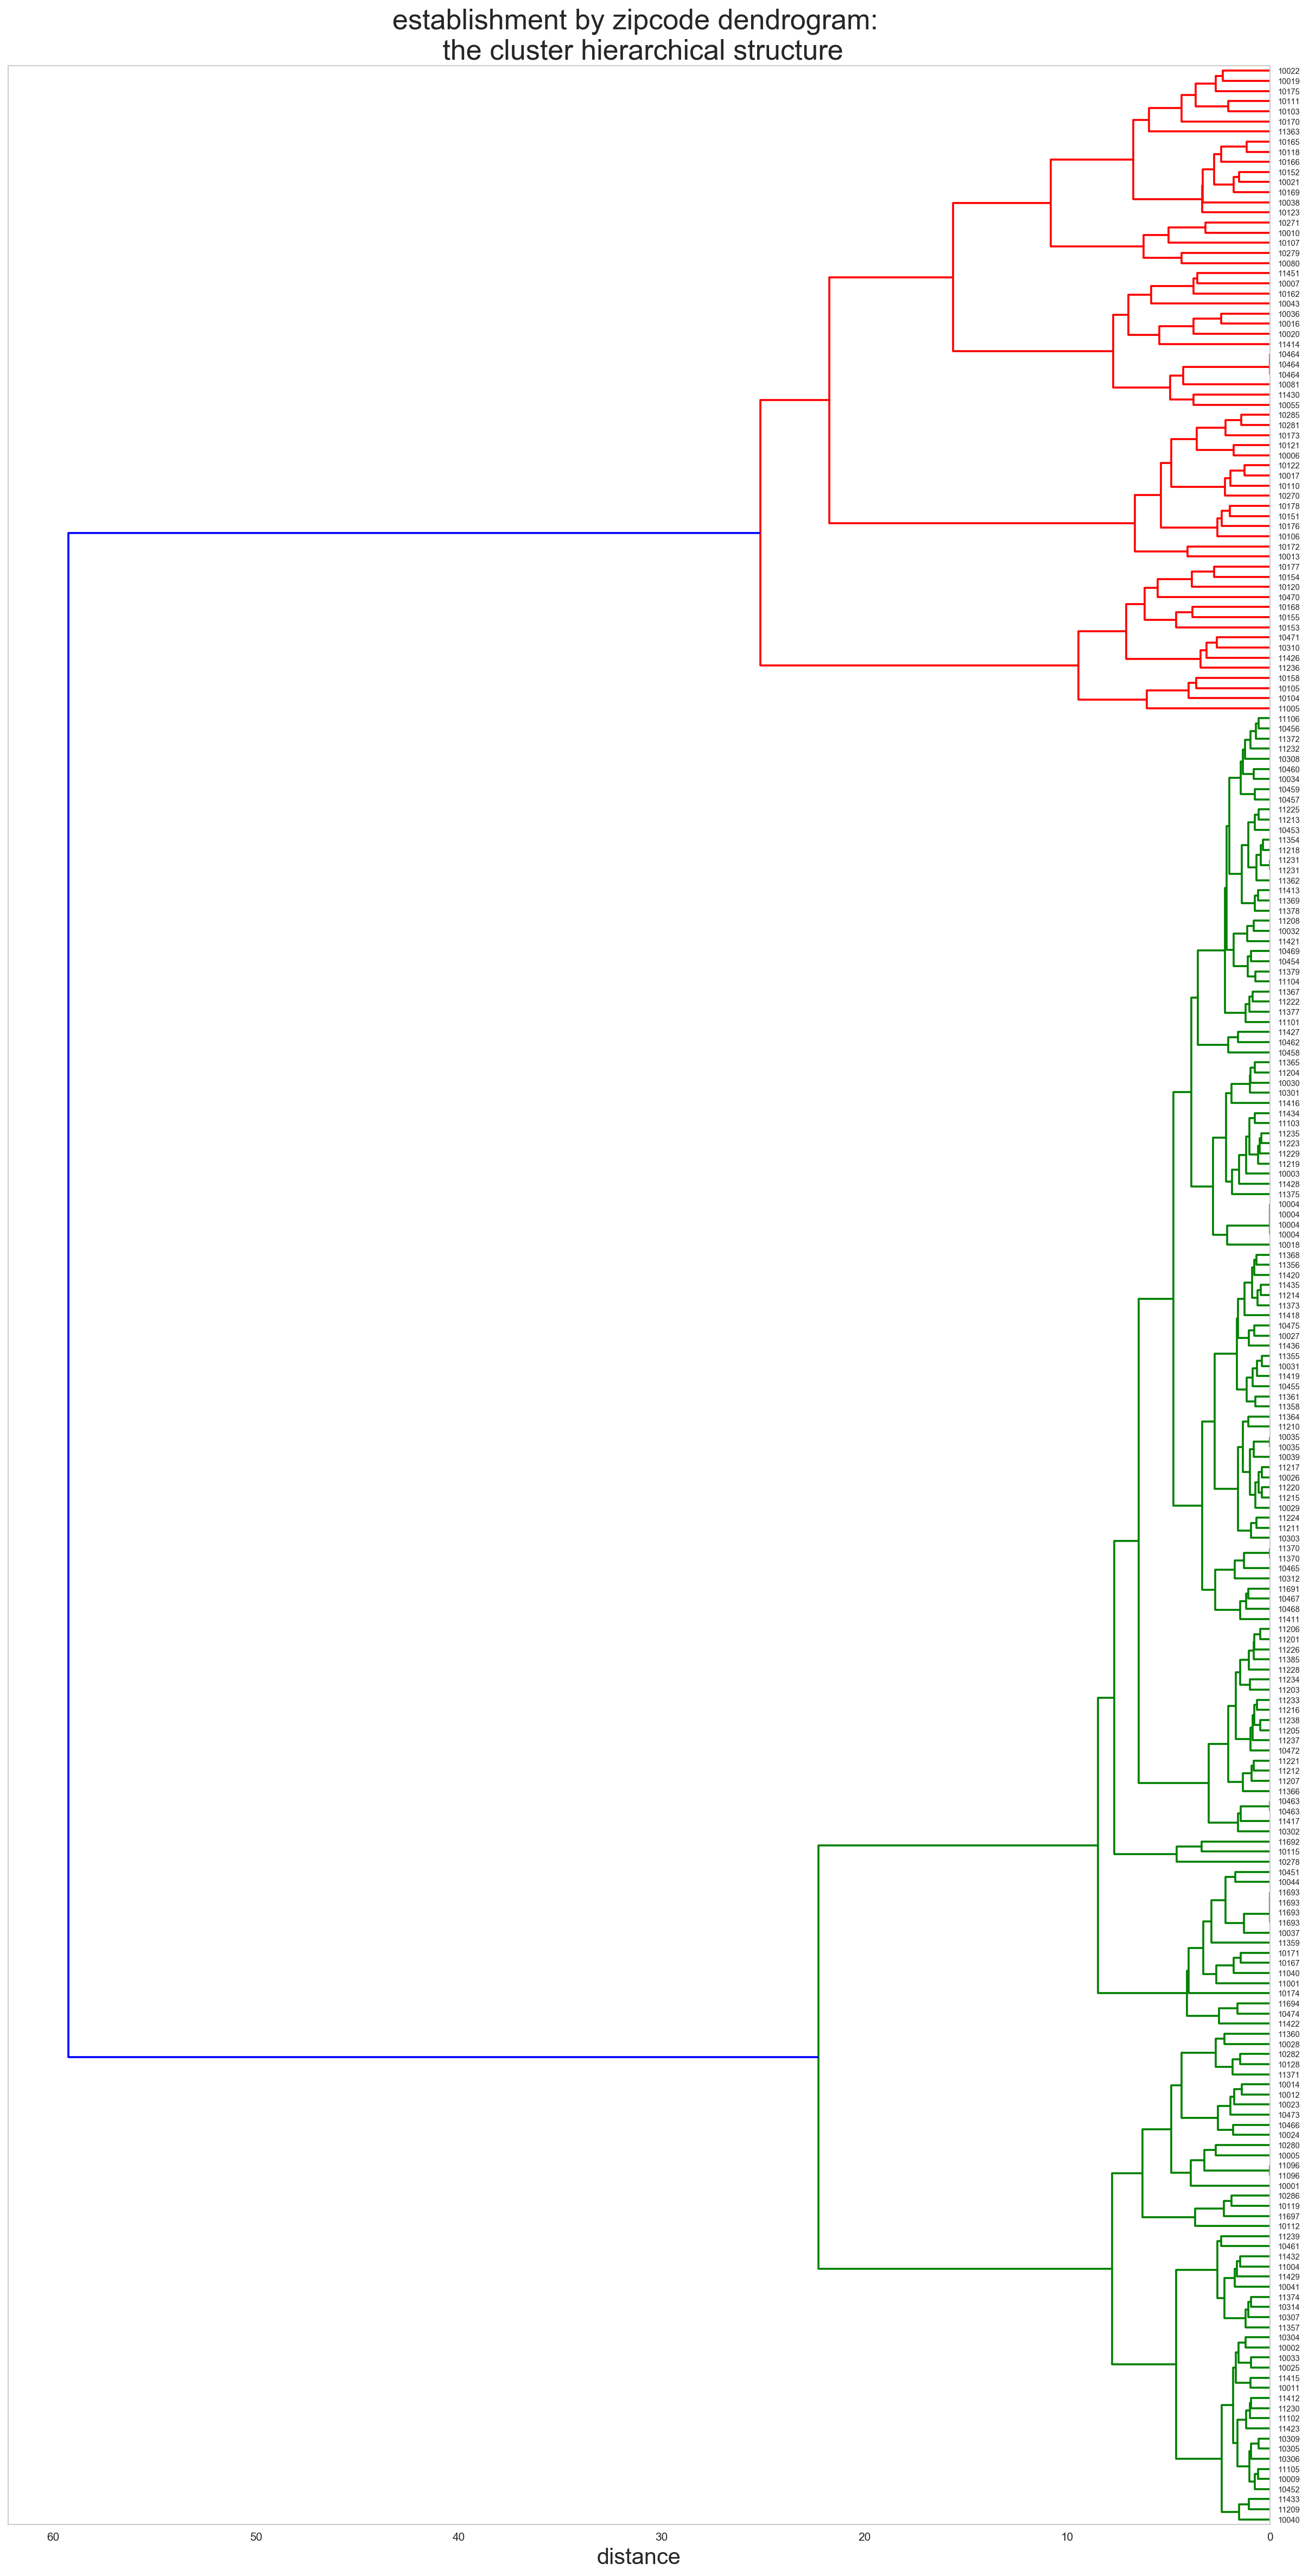

In [36]:
fig = pl.figure(figsize=(20,40), dpi=150)
pl.xlabel("distance", fontsize = 20 )
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(normData, method='ward'),
                               labels = normData.index,orientation = "left",  # rotates the x axis labels
                               leaf_font_size=7.)  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.grid('off')
title = pl.title("establishment by zipcode dendrogram: \n the cluster hierarchical structure", fontsize=25)
#this is a dendrogram for inspection of the hierarchical structure

__Figure 3__ : dandrogram of establishments' timeseries clusters, eucledian distance, Ward linkage.

To be consistent with before, we get 6 clusters

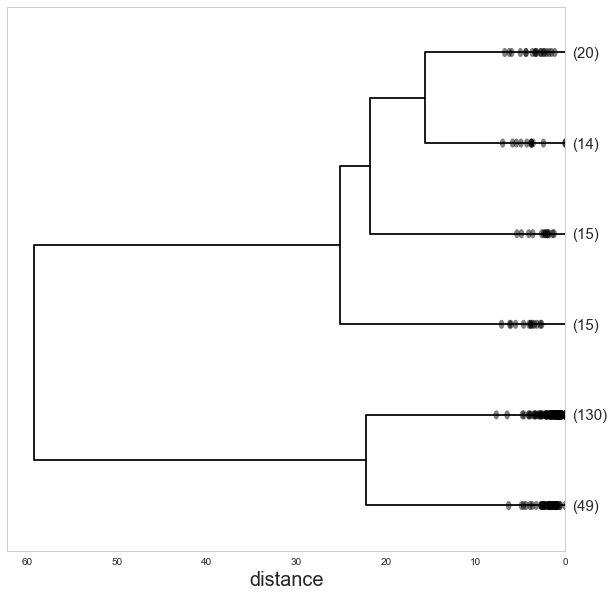

In [37]:
fig = pl.figure(figsize=(10,10))

ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(normData, method='ward'),
                               labels = normData.index,
                               leaf_rotation=90.,# rotates the x axis labels
                               leaf_font_size=20, truncate_mode='lastp', p=6, 
                               show_contracted=True, color_threshold = 2, 
                               orientation='left', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.xlabel("distance", fontsize=20)
pl.yticks(fontsize=15, rotation=0)
pl.grid('off')
#scp.hierarchy.dendrogram?

__Figure 4__: dandrogram of establishments' timeseries clusters, eucledian distance, Ward linkage, truuncated at the last 6 non-singleton

In [38]:
max_d = 12 #to have 6 clusters as before
clusters_ddg = fcluster(scp.hierarchy.linkage(normData, method='ward'), max_d, criterion='distance')

In [39]:
normDataGeo["clusters_ddg"] = clusters_ddg

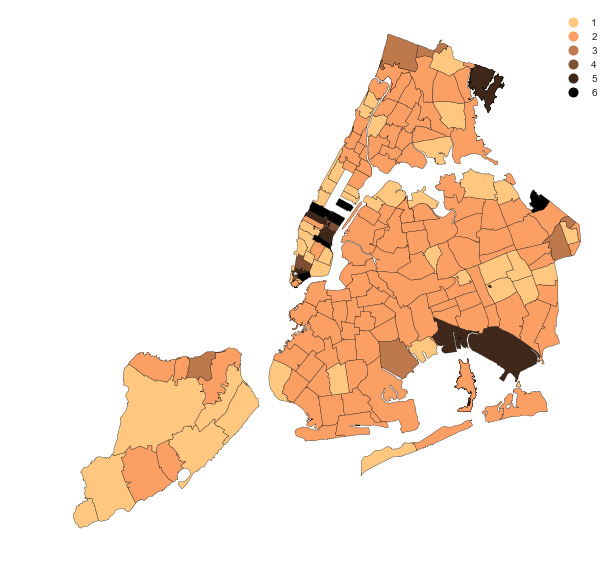

In [40]:
fig, ax = pl.subplots(figsize=(10, 10))
axis("off")
normDataGeo.plot(column = "clusters_ddg", ax=ax, edgecolor='black', categorical = True, cmap = "copper_r",legend = True);

__Figure 5__ : Cloropleth of NYC by zipcode, clustered by number of establishment's timeseries from 1994 to 2004. Clustering algorithm = hierarchical clustering with 6 clusters.

To compare the two algorithms, I will visualize them side-by-side to make an easier comparison. These figures are just duplicates of the ones above...

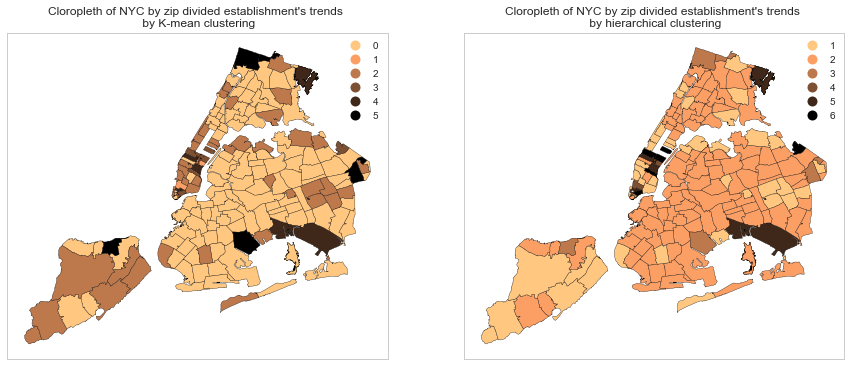

In [41]:
fig, (ax1,ax2) = pl.subplots(1,2,figsize=(15, 6))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
normDataGeo.plot(column = "cluster", ax= ax1, edgecolor='black', categorical = True, cmap = "copper_r",legend = True);
ax1.title.set_text("Cloropleth of NYC by zip divided establishment's trends \n by K-mean clustering")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
normDataGeo.plot(column = "clusters_ddg", ax=ax2, edgecolor='black', categorical = True, cmap = "copper_r",legend = True);
ax2.title.set_text("Cloropleth of NYC by zip divided establishment's trends \n by hierarchical clustering")

__Figure 6__ : Comparision between the chloropleths generated by two different algorithms. The two produce a similar division of establishment's trends by zip-code.

#### Interpretation

Looking at time series 0 and 2, we find that zipcodes in these clusters have seen a steady incraese in number of establishments since 1994. These areas are mainly associated with the outer boroughs: Brooklyn, Queens and the Bronx 's zipcodes mainly belong to these clusters.

Midtown's and lower Manhattan's zip codes display more varied trends, as we can see from for example the time series of cluster 3 or 5. These seem to be decreasing in numbers. 

One other interesting observation, is that some time curves display a decrease in establishment around between 2004 and 2010, which is during the economic recession -- this _might_ have affected number of establishments in certain zipcodes.

However, as there is many clustering algorithm and different ways of organizing these trends, it is difficult to jump to proper conclusion.

From this analysis, we could gather that it would be interesting to look at how downtown/midtown establishments' trends differ from the one of outer broughous.